# 作业说明：

数据挖掘互评作业四：离群点分析与异常检测

1. 问题描述

本次作业将从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个进行分析。

2. 数据来源

Anomaly Detection Meta-Analysis Benchmarks

注意：第一个不是数据集，是用于生成benchmark数据的代码。

可以使用Python Outlier Detection (PyOD)或其他已知的工具包来完成分析工作。

3. 提交的内容

完整的分析代码
分析报告：展示分析的思路，详细过程，结果及你的分析。
所选择的数据集在README中说明，数据文件不要上传到Github中
乐学平台提交注意事项：

仓库地址：记得加上
报告：附件，word，pdf，html格式都可以


# 1.实验步骤：
（1）在原始整体数据集上利用多种算法找到全局的离群点。

（2）分别评测各个算法（CBLOF，KNN，HBOS，PCA）的性能。
# 2.使用的算法描述：

实验中利用PyOD工具分别使用基于邻近性的CBLOF、KNN、HBOS及基于聚类的IForest、FeatureBagging异常检测算法。

1、CBLOF算法

CBLOF算法是基于聚类和邻近性的异常检测方法，它将数据分为香型集群和大型集群，然后根据点所属的簇的大小以及到最近的大簇的距离来计算异常分数。

2、KNN算法

KNN算法是典型的基于邻近性的异常检测算法，对于任何数据点，到第k个最近邻居的距离可以被视为远离分数，PyOD支持三个KNN探测器，分别为最大KNN、均值KNN以及中位数KNN，区别在于作为离群值得分的距离的计算方法。在这里我们用默认的最大KNN算法，也就是使用最大距离作为离群值。

3、HBOS算法

 是一种线性复杂度的异常检测算法，它比多变量方法快得多，但代价是精度较低。HBOS算法基于多维数据各个维度的独立性假设，对于单个数据维度，先做出数据直方图。对于categroy 值，统计每个值出现的次数，并计算相对频率
 
4、PAC算法

PCA通过线性变换将原始数据变换为一组各维度线性无关的表示，可用于提取数据的主要特征分量，常用于高维数据的降维。

我们在本研究中使用AUC指标，AUC指标是模型评测常用的指标之一，直观含义是任意取一个正样本和负样本，正样本得分大于负样本的概率。


In [3]:
import pandas as pd
import numpy as np
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import os
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from pyod.utils.data import get_outliers_inliers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from time import *
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from pyod.utils.utility import precision_n_scores

## 1. 选用数据集1：skin_benchmarks
该数据集中标注后的原始数据skin.preproc.csv中包括的9个数据列，分别为point.id、motherset、origin、original.label、diff.score、ground.truth、R、G、B，其中重要的是ground.truth、R、G、B，ground.truth为标注好的正确标签，R、G、B为数据属性特征值，用来进行预测。

划分后的子数据集共包括1500个.csv数据文件（注：文件的最大标号为1740，但实际只包括了1500个文件），每个子数据文件的主要数据列和原始数据相同。 
###  1.1 整体数据集异常检测和算法评测

In [12]:
path_1 = 'C:/Users/BIAN/Downloads/skin_benchmarks/skin/benchmarks'

names_1 = os.listdir(path_1)
paths_1 = []
for i in range(len(names_1)):
    paths_1.append(os.path.join(path_1,names_1[i]))
    
df= pd.read_csv(paths_1[0])

print('在数据集的benchmarks目录下包含1500个skin_benchmark文件，每个benchmark文件中包含6000条记录，\
      选取R\G\bB三个属性以及ground.truth进行离群点分析与异常检测。')
df.head()

在数据集的benchmarks目录下包含1500个skin_benchmark文件，每个benchmark文件中包含6000条记录，      选取R\GB三个属性以及ground.truth进行离群点分析与异常检测。


,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


In [13]:
count = 0
all_count = 0
for i in range(len(paths_1)):
    data_1 = pd.read_csv(paths_1[i])

    count += data_1.shape[0]
    all_count += data_1[data_1['ground.truth']=='nominal'].shape[0]
    

print('原始数据的正常点数量{}，离群点数量{}'.format(all_count,count-all_count))
    

原始数据的正常点数量8207355，离群点数量791724


非异常点和异常点的3D显示


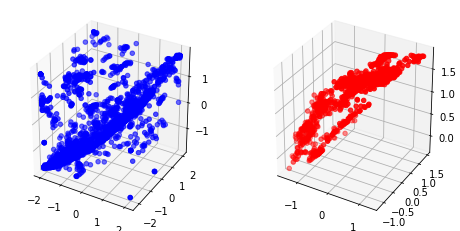

In [14]:
r = df['R'][df['ground.truth']=='anomaly']
g = df['G'][df['ground.truth']=='anomaly']
b = df['B'][df['ground.truth']=='anomaly']

r_no = df['R'][df['ground.truth']=='nominal']
g_no = df['G'][df['ground.truth']=='nominal']
b_no = df['B'][df['ground.truth']=='nominal']

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter3D(r_no,g_no ,b_no ,c='b')

ax = fig.add_subplot(1,2,2,projection='3d')
ax.scatter3D(r,g,b,c='r')

print('非异常点和异常点的3D显示')
plt.show()


In [24]:

train_scale = 1

normal = []
non_normal = []
right_num = []
score_1 = []

AUC_1 =[]
AP_1 = []

name = ['CBLOF','KNN','HBOS','PCA']
for i in range(len(name)):
    print(name[i])
    
    if i==0:
        clf = CBLOF(random_state=np.random.RandomState(42))
    elif i==1:
        clf = KNN(n_neighbors = 5) 
    elif i==2:
#         clf = IForest(contamination=outliers_fraction,random_state=random_state)
        clf = HBOS()
    else:
        clf = PCA() 
            
    sum_normal = 0
    sum_nonnormal = 0
    sum_right = 0
    for i in range(len(paths_1)):

        if i%500==0:
            print(i)
        df = pd.read_csv(paths_1[i])

        data = df[['R','G','B']]
        label = np.where(df['ground.truth']=='nominal',0,1)


        data_train = data[:int(train_scale*len(data))]

        data_test = data[int(train_scale*len(data)):]

        data_train_label = label[:int(train_scale*len(data))]

        data_test_label = label[int(train_scale*len(data)):]


        clf.fit(data_train)

        y_pred = clf.labels_

        n_out = np.count_nonzero(y_pred)
        n_normal = len(y_pred)- n_out
        
        AUC_1.append(roc_auc_score(data_train_label,y_pred))
        AP_1.append(average_precision_score(data_train_label, y_pred))

        sum_normal+=n_normal
        sum_nonnormal+=n_out

        sum_right +=np.equal(y_pred,data_train_label).sum()

    
    print('预测的情况：正常值：{}，异常值：{}，准确率：{}'.format(sum_normal,sum_nonnormal,sum_right/(sum_nonnormal+sum_normal)))
    normal.append(sum_normal)
    non_normal.append(sum_nonnormal)
    right_num.append(sum_right)
    score_1.append(sum_right/(sum_nonnormal+sum_normal))
    


    


CBLOF
0
500
1000
预测的情况：正常值：8099279，异常值：899800，准确率：0.8266629285063505
KNN
0
500
1000
预测的情况：正常值：8099277，异常值：899802，准确率：0.82299210841465
HBOS
0
500
1000
预测的情况：正常值：8129193，异常值：869886，准确率：0.8241504491737432
PCA
0
500
1000
预测的情况：正常值：8099661，异常值：899418，准确率：0.8198975695179473


由上面的训练结果可以知道。
原始数据集中的正常点数量8207355，离群点数量791724，
我们通过4种算法预测的结果 正常点的数量平均为80万左右，异常点的数量为89万左右，


计算了每个算法预测结果的准确率如下:
CBLOF算法的均值为0.826；KNN算法的均值为0.822；HBOS算法的均值为0.824；PCA 算法的均值为0.0.81；
其中CBLOF算法在该数据集上的性能较好。


In [28]:
AUC_end = []
for i in [0.25,0.5,0.75,1]:
    AUC_end.append(np.mean(AUC_1[int((i-0.25)*len(AUC_1)):int(i*len(AUC_1))]))

print('每个算法的AUC值')
print('AUC: CBLOF：{}，KNN：{}，HBOS：{}，PCA：{} '.format(AUC_end[0],AUC_end[1],AUC_end[2],AUC_end[3]))

print('从AUC值看，KNN算法性能较为稳定，它的性能受到离群点所占比例的影响是比较小的。')


每个算法的AUC值
AUC: CBLOF：0.6106872466927874，KNN：0.6771319635751973，HBOS：0.5026159475817054，PCA：0.4769085121266091 
从AUC值看，KNN算法性能较为稳定，它的性能受到离群点所占比例的影响是比较小的。


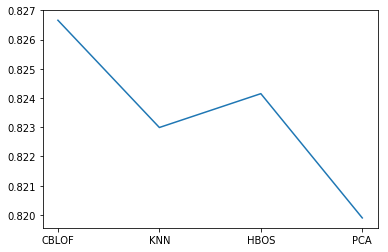

In [141]:

name_1 = ['CBLOF','KNN','HBOS','PCA']
plt.plot(name_1,score_1)
plt.show()


In [ ]:
根据预测的结果可以看出，CBLOF的准确率较高


# 2 abalone-benchmark
## 2.1 数据集分析
在数据集的benchmarks目录下包含1725个skin_benchmark文件，每个benchmark文件中包含1888条记录，选取V1-V7七个属性以及ground.truth进行离群点分析与异常检测

In [16]:
path_2 = 'C:/Users/BIAN/Downloads/abalone_benchmarks/abalone/benchmarks/'
name_2 = os.listdir(path_2)
paths_2 =[]
for i in range(len(name_2)):
    paths_2.append(os.path.join(path_2,name_2[i]))
df_2= pd.read_csv(paths_2[0])

df_2.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1584,abalone,regression,7,0.153312,nominal,-0.116511,-0.129799,-0.227518,-0.461352,-0.353066,-0.342963,-0.551935
1,abalone_point_0315,abalone,regression,23,0.202253,anomaly,0.882716,0.777094,0.848341,0.960988,0.333986,1.039157,1.588828
2,abalone_point_1779,abalone,regression,8,0.562701,nominal,-0.283048,-0.532863,0.489721,0.103505,-0.048961,0.313886,0.313709
3,abalone_point_1926,abalone,regression,11,0.209155,anomaly,0.716178,0.625945,0.609261,0.713225,0.930932,0.893190,0.396322
4,abalone_point_0588,abalone,regression,13,0.163268,anomaly,0.216565,0.021350,0.131102,-0.000494,-0.224666,0.090375,0.080237


In [17]:
count = 0
all_count = 0
for i in range(len(paths_2)):
    data_2 = pd.read_csv(paths_2[i])

    count += data_2.shape[0]
    all_count += data_2[data_2['ground.truth']=='nominal'].shape[0]
    

print('原始数据的正常点数量{}，离群点数量{}'.format(all_count,count-all_count))

原始数据的正常点数量2488142，离群点数量324743


In [6]:
train_scale = 1

normal_2 = []
non_normal_2 = []
right_num_2 = []
score_2 = []

AUC_2 =[]
AP_2 = []
name = ['CBLOF','KNN','HBOS','PCA']
for i in range(len(name)):
    print(name[i])
    
    if i==0:
        clf = CBLOF(random_state=42)
    elif i==1:
        clf = KNN(n_neighbors = 5) 
    elif i==2:
#         clf = IForest(contamination=outliers_fraction,random_state=random_state)
        clf = HBOS()
    else:
        clf = PCA() 
        
    sum_normal = 0
    sum_nonnormal = 0
    sum_right = 0
    for i in range(len(paths_2)):

        if i%500==0:
            print(i)
        df = pd.read_csv(paths_2[i])

        data = df[['V1','V2','V3','V4','V5','V6','V7']]
        label = np.where(df['ground.truth']=='nominal',0,1)


        data_train = data[:int(train_scale*len(data))]
#         print(data_train.shape)

        data_test = data[int(train_scale*len(data)):]

        data_train_label = label[:int(train_scale*len(data))]

        data_test_label = label[int(train_scale*len(data)):]


        clf.fit(data_train)

        y_pred = clf.labels_
        

        n_out = np.count_nonzero(y_pred)
        n_normal = len(y_pred)- n_out
        AUC_2.append(roc_auc_score(label,y_pred))
        AP_2.append(average_precision_score(label, y_pred))

        sum_normal+=n_normal
        sum_nonnormal+=n_out

        sum_right +=np.equal(y_pred,data_train_label).sum()

    
    print('正常值：{}，异常值：{}，预测准确率：{}'.format(sum_normal,sum_nonnormal,sum_right/(sum_nonnormal+sum_normal)))
    normal_2.append(sum_normal)
    non_normal_2.append(sum_nonnormal)
    right_num_2.append(sum_right)
    score_2.append(sum_right/(sum_nonnormal+sum_normal))

CBLOF
0
500
1000
1500
正常值：2531001，异常值：281884，预测准确率：0.8269239588536325
KNN
0
500
1000
1500
正常值：2531038，异常值：281847，预测准确率：0.835470700010843
HBOS
0
500
1000
1500
正常值：2535647，异常值：277238，预测准确率：0.8348005695220387
PCA
0
500
1000
1500
正常值：2531001，异常值：281884，预测准确率：0.8221011523755859


In [29]:
AUC_end = []
for i in [0.25,0.5,0.75,1]:
    AUC_end.append(np.mean(AUC_2[int((i-0.25)*len(AUC_2)):int(i*len(AUC_2))]))


print('每个算法的AUC值')
print('AUC: CBLOF：{}，KNN：{}，HBOS：{}，PCA：{} '.format(AUC_end[0],AUC_end[1],AUC_end[2],AUC_end[3]))
print('从AUC值看，KNN算法性能较为稳定，它的性能受到离群点所占比例的影响是比较小的。')         

每个算法的AUC值
AUC: CBLOF：0.637167943092218，KNN：0.664305676583141，HBOS：0.6641891955318046，PCA：0.629981850164103 
从AUC值看，KNN算法性能较为稳定，它的性能受到离群点所占比例的影响是比较小的。


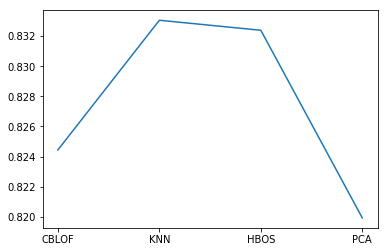

In [111]:
plt.plot(name,score)
plt.show()

根据预测的结果可知，非异常值的预测数量基本一致，在对异常值的预测上，数量差距较大，最大差距为3000个，准确率都在80%以上，其中KNN表现的比较好，HBOS也表现了很好的异常点检测能力。